# 21. A/B Testing Examples

In [1]:
from datascience import *
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from scipy import stats

We will continue to work with a subset of the `personality` table called `pers` which is suitable for A/B Testing using numeric variables Narcissism and Perfectionism.

In [2]:
pers = Table.read_table('http://faculty.ung.edu/rsinn/perfnarc.csv')
pers.show(5)

Sex,G21,Greek,AccDate,Stress1,Stress2,Perf,Narc
F,N,N,N,9,7,99,3
F,Y,N,Y,11,13,86,2
F,N,Y,N,15,14,118,4
F,N,N,Y,16,15,113,2
F,Y,N,Y,17,17,107,8


## A/B Hypothesis Testing

The basic process of A/B testing requires a grouping variable with two independent levels and a numeric variable of interest. *Independent levels* means that no participant, not even theoretical ones, could simultaneously be in both groups A and B.

````{margin}
```{tip}
We often write hypotheses in symbolic form where the Greek letter $\mu$ indicates *mean*.

$$H_0 : \mu_A = \mu_B\\H_a : \mu_A \neq \mu_B$$

The null hypothesis is abbreviated as $H_0$ while the alternative hypothesis is $H_a$.
```
````

1. **Null hypothesis.** Groups A/B drawn from same distribution, e.g. *no difference in A/B group means*.
2. **Alternative hypothesis.** Groups A/B drawn from different distributions, e.g. *significant difference in A/B group means*.
3. **Test statistic**. Difference in means between shuffled A/B groups
4. Simulate test statistic distribution
5. Calculate **$p$-value**, e.g. the probability the null hypothesis is true.
6. **Statistical Conclusion.** If $p<0.05$, reject null. Else, fail to reject null.
7. **Real world implications.** State the results of hypothesis test in real world terms.

## Example: Perfectionism

In the [A/B Testing Tools](../0.ipynb) section, we developed three helpful functions for A/B testing. Execute each code block so the functions are active.

In [3]:
def ab_shuffle(tab):
    shuffle_group = tab.sample(with_replacement = False).column(0)
    shuffled_tab = tab.with_column("Shuffled Grouping",shuffle_group).select(2,1)
    return shuffled_tab

In [4]:
def ab_diff(tab):
    tab.group(0,np.average)
    a_mean = tab.group(0,np.average).column(1).item(0)
    b_mean = tab.group(0,np.average).column(1).item(1)
    return a_mean - b_mean

In [5]:
def ab_hist(myArray, observed_value):
    tab = Table().with_column('A/B Differencs',myArray)
    tab.hist(0)
    _ = plots.plot([observed_value, observed_value], [0, 0.1], color='red', lw=2)

## Example with perfectionism

Let's conduct an A/B test on the perfectionism variable noting each step as we go. Our research question is whether perfectionism scores differ based upon biological sex. We take care to produce a two-column table with the grouping variable in the first column and the numeric variable in the second. 

In [6]:
perf = pers.select('Sex','Perf')
perf

Sex,Perf
F,99
F,86
F,118
F,113
F,107
F,123
F,93
F,126
F,91
F,111


### Hypotheses

The **null hypothesis** is that the A/B groups were drawn from the same distribution. If that were the case, shuffling the labels of the grouping variables will not matter much at all. The observed difference will appear very likely when compared to the simulated test statistic distribution.

The **alternative hypothesis** is that there is some significant difference between the two distributions. If so, the observed difference will look very different than the simulated test statistic distribution.

We can use the `ab_diff` function to calculate the observed difference between the A/B groups.

In [7]:
obs_diff = ab_diff(perf)
obs_diff

2.5915966386554743

### Simulating the test statistic

We can use the `ab_shuffle` and `ab_diff` functions together to simulate one test statistic. Run the code block below several times. You should observe both positive and negative values and learn what typical values in the test statistic distribution look like.

In [8]:
ab_diff(ab_shuffle(perf))

0.18711484593836758

Now we simulate the test statistic distribution and store the results in an array called `perf_diffs`.

In [9]:
perf_diffs = make_array()

# Set reps at 1,000 or less especially if running this in the cloud.
reps = 2500

for i in range(reps):
    new_diff = ab_diff(ab_shuffle(perf))
    perf_diffs = np.append(perf_diffs, new_diff)

# Remove comment below to see the array created by the for loop
# perf_diffs    

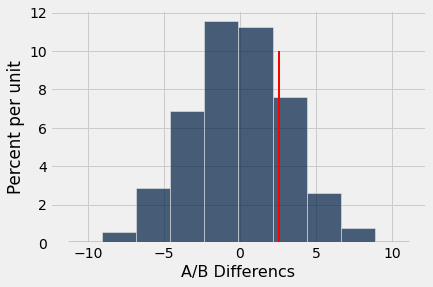

In [10]:
ab_hist(perf_diffs,obs_diff)

### Calculate $p$-value.

We first create a truth array to determine how often the simulated test statistics were as extreme (or more extreme) than the observed difference. We can sum the truth array and divide by the number of simulated statistics created by the `for` loop.

In [11]:
sum(perf_diffs >= obs_diff)

523

In [12]:
p_value = sum(perf_diffs >= obs_diff) / reps 
p_value

0.2092

### Conclusion

Since $p\approx 0.2>0.05$, we fail to reject the null since it might well be true. In real world terms, we have found no significant differences in the perfectionism levels based upon biological sex.

## Example 2: Narcissism

The `AccDate` variable is the Yes/No responses from UNG college students to this dating question: "At a time in your life when you are not involved with anyone, a person asks you out. This person has a great personality, but you do not find them pysically attractive. Do you accept the date?"

*Research Question.* Will those who have higher levels of narcissism say "No" to the date more often? We can use the `pers` data to test whether Yes-group or No-group on the dating question have higher levels of narcissism.

In [13]:
narc = pers.select('AccDate','Narc')
narc.show(5)

AccDate,Narc
N,3
Y,2
N,4
Y,2
Y,8


In [14]:
narc.group('AccDate',np.average)

AccDate,Narc average
N,5.29688
Y,4


There appears to be some difference in the A/B group means. Let's conduct the hypothesis test.

In [15]:
obs_diff_narc = ab_diff(narc)
obs_diff_narc

1.296875

In [16]:
narc_diff = make_array()

# Set reps to 1,000 or less, especially if using the cloud
reps = 2500

for i in range(reps):
    new_diff = ab_diff(ab_shuffle(narc))
    narc_diff = np.append(narc_diff,new_diff)
    
# Remove comment hashtag below to see results array
#narc_diff

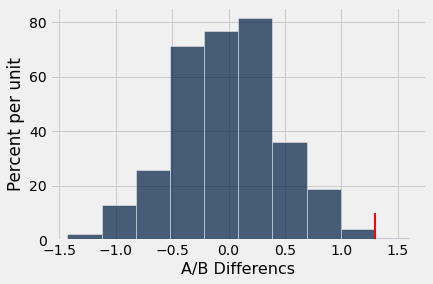

In [17]:
ab_hist(narc_diff, obs_diff_narc)

In [18]:
p = sum(narc_diff >= obs_diff_narc) / reps
p

0.0024

Since $p = 0.004 < 0.05$, we reject the null. We have strong evidence that those who say "No" to the date also have significantly higher levels of narcissism than those who say "Yes."